In [1]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
tsla = yf.Ticker("tsla")

tsla_hist = tsla.history(period='5y', interval='1d', start='2020-01-01')
tsla_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500,0.0,0.0
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500,0.0,0.0
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000,0.0,0.0
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500,0.0,0.0
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500,0.0,0.0
...,...,...,...,...,...,...,...
2025-06-09 00:00:00-04:00,285.959991,309.829987,281.850006,308.579987,140908900,0.0,0.0
2025-06-10 00:00:00-04:00,314.940002,327.829987,310.670013,326.089996,151256500,0.0,0.0
2025-06-11 00:00:00-04:00,334.399994,335.500000,322.500000,326.429993,122611400,0.0,0.0


In [3]:
tsla_hist.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

In [4]:
tsla_hist.index =pd.to_numeric(tsla_hist.index)
tsla_hist.index = tsla_hist.index/(max(tsla_hist.index))

In [5]:
for col in tsla_hist.columns:
    tsla_hist[col] = tsla_hist[col]/max(tsla_hist[col])

In [6]:
class MLP(nn.Module):
    def __init__(self, input_features, hidden_features, output_features):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Linear(input_features, hidden_features),
            nn.ReLU()
        )
        self.l2 = nn.Sequential(
            nn.Linear(hidden_features, output_features),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

In [7]:
X = tsla_hist.drop(columns=['Close'])
y = tsla_hist['Close']

In [8]:
X['Date'] = X.index

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

pca.fit(X, y)

PCA(n_components=5)

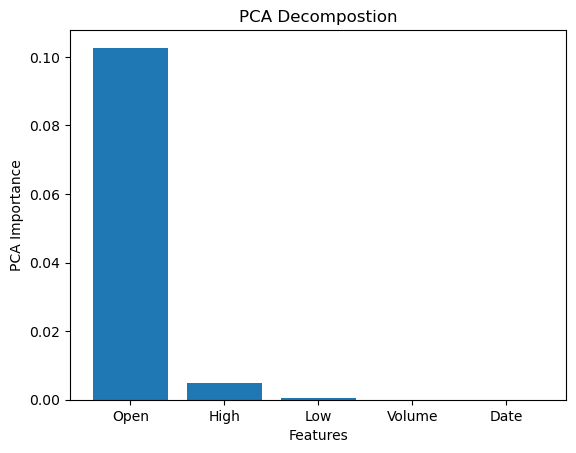

In [10]:
import matplotlib.pyplot as plt

plt.bar(X.columns, pca.explained_variance_)
plt.xlabel('Features')
plt.ylabel('PCA Importance')
plt.title("PCA Decompostion")
plt.show()

In [11]:
for delay in range(1,4):
    X[f"Delay {delay}"] = y.iloc[(3-delay):-(delay)]

In [12]:
X

,Open,High,Low,Volume,Date,Delay 1,Delay 2,Delay 3
Date,,,,,,,,
0.901790,0.059466,0.058774,0.061450,0.156421,0.901790,NaN,NaN,0.059776
0.901840,0.061708,0.061953,0.063666,0.291744,0.901840,NaN,0.061547,0.061547
0.901988,0.061703,0.061620,0.064115,0.166282,0.901988,0.062732,0.062732,0.062732
0.902037,0.064635,0.064359,0.066062,0.293444,0.902037,0.065166,0.065166,0.065166
0.902087,0.066358,0.068024,0.068229,0.511075,0.902087,0.068373,0.068373,0.068373
...,...,...,...,...,...,...,...,...
0.999802,0.600883,0.634196,0.616052,0.154153,0.999802,0.643063,0.643063,0.643063
0.999852,0.661778,0.671040,0.679045,0.165474,0.999852,0.679552,0.679552,0.679552
0.999901,0.702669,0.686740,0.704903,0.134136,0.999901,0.680261,0.680261,NaN


In [13]:
X_sample = [[d, h, l, o, vol, v1, v2, v3] for d, h, l, o, vol, v1, v2, v3 in zip(X['Date'].iloc[3:].values, X['High'].iloc[3:].values, X['Low'].iloc[3:].values,X['Open'].iloc[3:].values, X['Volume'].iloc[3:].values, X['Delay 1'].dropna().values, X['Delay 2'].dropna().values, X['Delay 3'].dropna().values)]
y_sample = y.iloc[3:].values

In [14]:
len(X['Date'].iloc[3:].values), len(X_sample)

(1367, 1367)

In [15]:
len(y_sample), len(X_sample)

(1367, 1367)

In [16]:
X = torch.from_numpy(np.array(X))
y = torch.from_numpy(np.array(y))

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
len(X_test)

274

In [19]:
train_data = [(X,y) for X, y in zip(X[:-273], y[:-273])]
test_data = [(X,y) for X, y in zip(X[-273:], y[-273:])]

In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloaader= DataLoader(test_data, batch_size=32, shuffle=True)

In [21]:
mlpmodel = MLP(8, 32, 1)

In [22]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(params=mlpmodel.parameters(), lr=0.01)